In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

二元資料集：The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes.

In [3]:
# 讀取數據集
data = pd.read_csv('step_preprocessing\\data_binary_after_preprocessing.csv')
data = data.drop('Unnamed: 0', axis=1)

# 分離特徵和目標變量
drop_list = ['Diabetes_binary', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
X = data.drop(drop_list, axis=1)
y = data['Diabetes_binary']

# 分割數據集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

三元資料集：The target variable Diabetes_012 has 3 classes. 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes.

In [52]:
# 讀取數據集
data = pd.read_csv('step_preprocessing\\data_012_after_preprocessing.csv')
data = data.drop('Unnamed: 0', axis=1)

# 分離特徵和目標變量
drop_list = ['Diabetes_012', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
X = data.drop(drop_list, axis=1)
y = data['Diabetes_012']

# 分割數據集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

Examine the class label imbalance

In [82]:
neg, pos = np.bincount(data['Diabetes_binary'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 253680
    Positive: 35346 (13.93% of total)



In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.array([0, 1]), 
                                     y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

[0.58134343 3.57338914]


## 尋找隨機森林最佳超參數

隨機森林超參數列表

In [5]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


建立超參數網格，以便採樣

In [18]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [19]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [21]:
# 訓練隨機森林模型
model = RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=2000, n_jobs=-1, random_state=42, class_weight=class_weights_dict)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5813434252826902,
                                     1: 3.5733891415462633},
                       max_depth=40, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=42)

In [13]:
# 預測訓練集和測試集
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 計算訓練集和測試集的準確率
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 顯示準確率
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Testing Accuracy: {test_accuracy:.2f}')

Training Accuracy: 0.88
Testing Accuracy: 0.81


In [22]:
# 顯示特徵重要性
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# 特徵重要性
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")

Feature ranking:
BMI_afterNormalization: 0.16128385387067376
GenHlth_afterNormalization: 0.14246815139390231
Age_afterNormalization: 0.11918550641939268
HighBP: 0.11304639917370701
Income_afterNormalization: 0.06757182947242592
PhysHlth_afterNormalization: 0.0604261482440995
HighChol: 0.052043930238249804
MentHlth_afterNormalization: 0.04543357177615629
Education_afterNormalization: 0.04402473580377841
DiffWalk: 0.03484677809468667
HeartDiseaseorAttack: 0.021890666747126388
Smoker: 0.02078174563617224
Fruits: 0.020636095849407097
Sex: 0.020490522495290913
PhysActivity: 0.018256114112825437
Veggies: 0.01680128843210588
HvyAlcoholConsump: 0.009927645807771923
NoDocbcCost: 0.009614342853621808
Stroke: 0.00822543450632368
CholCheck: 0.006969422431893666
AnyHealthcare: 0.00607581664038866


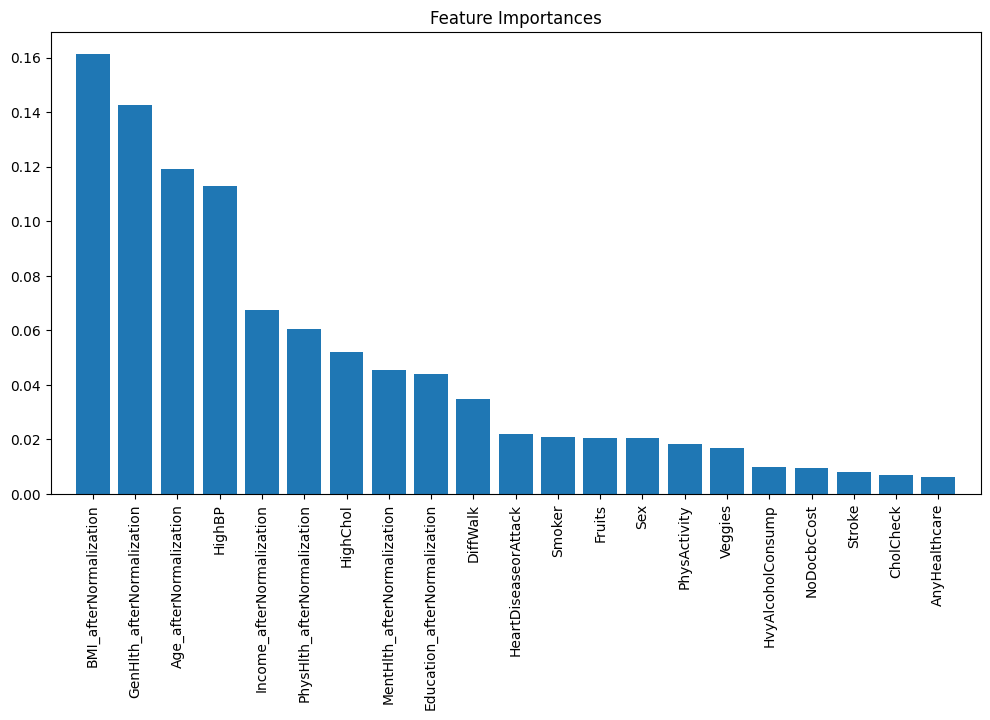

In [23]:
# 繪製特徵重要性圖
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     65605
         1.0       0.39      0.54      0.46     10499

    accuracy                           0.82     76104
   macro avg       0.66      0.70      0.67     76104
weighted avg       0.85      0.82      0.83     76104

[[56828  8777]
 [ 4809  5690]]
